# Face Generation
In this project, I'll use generative adversarial networks to generate new images of faces.
### Get the Data
I'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex, I will test my neural network on MNIST before CelebA.  Running the GANs on MNIST will allow me to see how well my model trains sooner.

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
MNIST dataset contains images of handwritten digits:

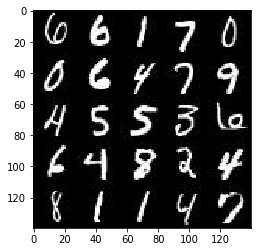

In [2]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since I am going to be generating faces, I won't need the annotations. 

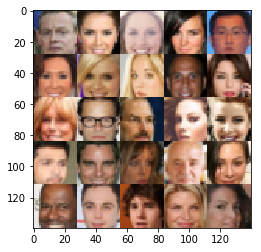

In [3]:
show_n_images = 25
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
`model_inputs` function creates TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=[], name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
`discriminator` creates a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    x = images
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(x, 64, 4, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)

        x = tf.layers.conv2d(x, 128, 4, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)

        x = tf.layers.conv2d(x, 256, 4, strides=2, padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)

        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
`generator` generates an image using `z`. This function should be able to reuse the variables in the neural network.  The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    alpha=0.2
    with tf.variable_scope('generator', reuse=reuse):
        x = tf.layers.dense(z, 4*4*512)
        
        x = tf.reshape(x, (-1,4,4,512))
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
        x = tf.layers.conv2d_transpose(x, 256, 4, strides=1, padding="valid")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
        x = tf.layers.conv2d_transpose(x, 128, 4, strides=2, padding="same")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
        x = tf.layers.conv2d_transpose(x, out_channel_dim, 4, strides=2, padding="same")

        logits = x
        out = tf.tanh(logits)
    
    return out

tests.test_generator(generator, tf)

Tests Passed


### Loss
`model_loss` builds the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss). 

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

tests.test_model_loss(model_loss)

Tests Passed


### Optimization
`model_opt` creates the optimization operations for the GANs.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
This function was provided to show the current output of the generator during training. It will help me determine how well the GANs is training.

In [10]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
`train` builds and trains the GANs.  
I will print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    if (data_image_mode == "L"):
        out_channel_dim=1
    else:
        out_channel_dim=3
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print_every=10
    show_every=100
    samples, losses = [], []
    steps=0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z=np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f} ...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                    
        show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)

### Test on  MNIST
After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  

Epoch 1/2... Discriminator Loss: 2.3882 ... Generator Loss: 0.1964
Epoch 1/2... Discriminator Loss: 0.8338 ... Generator Loss: 0.8567
Epoch 1/2... Discriminator Loss: 0.9136 ... Generator Loss: 0.9430
Epoch 1/2... Discriminator Loss: 1.3045 ... Generator Loss: 0.5063
Epoch 1/2... Discriminator Loss: 1.1837 ... Generator Loss: 2.1516
Epoch 1/2... Discriminator Loss: 0.8960 ... Generator Loss: 0.8728
Epoch 1/2... Discriminator Loss: 1.0783 ... Generator Loss: 0.5993
Epoch 1/2... Discriminator Loss: 0.7783 ... Generator Loss: 0.8621
Epoch 1/2... Discriminator Loss: 0.6667 ... Generator Loss: 1.4005
Epoch 1/2... Discriminator Loss: 1.0362 ... Generator Loss: 1.4496


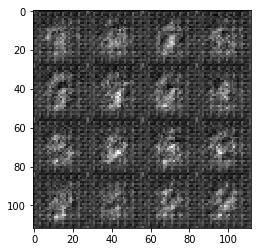

Epoch 1/2... Discriminator Loss: 1.0101 ... Generator Loss: 1.7811
Epoch 1/2... Discriminator Loss: 0.9518 ... Generator Loss: 0.8620
Epoch 1/2... Discriminator Loss: 0.9437 ... Generator Loss: 1.3294
Epoch 1/2... Discriminator Loss: 0.8371 ... Generator Loss: 1.1940
Epoch 1/2... Discriminator Loss: 1.0905 ... Generator Loss: 1.3114
Epoch 1/2... Discriminator Loss: 1.1402 ... Generator Loss: 1.3331
Epoch 1/2... Discriminator Loss: 1.1119 ... Generator Loss: 1.4711
Epoch 1/2... Discriminator Loss: 0.9330 ... Generator Loss: 1.1161
Epoch 1/2... Discriminator Loss: 1.1398 ... Generator Loss: 0.5180
Epoch 1/2... Discriminator Loss: 1.2098 ... Generator Loss: 0.4514


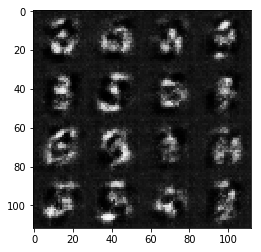

Epoch 1/2... Discriminator Loss: 0.9193 ... Generator Loss: 0.8526
Epoch 1/2... Discriminator Loss: 1.5177 ... Generator Loss: 0.3164
Epoch 1/2... Discriminator Loss: 0.9332 ... Generator Loss: 0.6718
Epoch 1/2... Discriminator Loss: 0.9189 ... Generator Loss: 0.6655
Epoch 1/2... Discriminator Loss: 0.8247 ... Generator Loss: 1.3262
Epoch 1/2... Discriminator Loss: 1.0876 ... Generator Loss: 2.4438
Epoch 1/2... Discriminator Loss: 0.7860 ... Generator Loss: 1.5207
Epoch 1/2... Discriminator Loss: 0.9817 ... Generator Loss: 1.9387
Epoch 1/2... Discriminator Loss: 0.9015 ... Generator Loss: 0.7176
Epoch 1/2... Discriminator Loss: 0.7965 ... Generator Loss: 1.1628


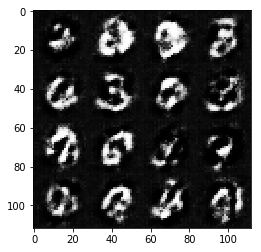

Epoch 1/2... Discriminator Loss: 1.0604 ... Generator Loss: 2.1274
Epoch 1/2... Discriminator Loss: 0.7396 ... Generator Loss: 1.4844
Epoch 1/2... Discriminator Loss: 0.8643 ... Generator Loss: 1.6479
Epoch 1/2... Discriminator Loss: 0.8099 ... Generator Loss: 0.9773
Epoch 1/2... Discriminator Loss: 0.9265 ... Generator Loss: 0.6570
Epoch 1/2... Discriminator Loss: 1.0927 ... Generator Loss: 0.5189
Epoch 1/2... Discriminator Loss: 0.7945 ... Generator Loss: 0.8038
Epoch 1/2... Discriminator Loss: 1.2454 ... Generator Loss: 0.4162
Epoch 1/2... Discriminator Loss: 0.7324 ... Generator Loss: 1.0113
Epoch 1/2... Discriminator Loss: 1.0111 ... Generator Loss: 0.5701


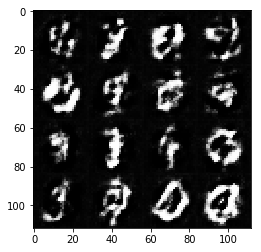

Epoch 1/2... Discriminator Loss: 0.8857 ... Generator Loss: 0.6932
Epoch 1/2... Discriminator Loss: 0.9218 ... Generator Loss: 0.6768
Epoch 1/2... Discriminator Loss: 0.8518 ... Generator Loss: 0.7060
Epoch 1/2... Discriminator Loss: 0.8592 ... Generator Loss: 0.7641
Epoch 1/2... Discriminator Loss: 0.8753 ... Generator Loss: 0.7002
Epoch 1/2... Discriminator Loss: 0.7066 ... Generator Loss: 0.9804
Epoch 1/2... Discriminator Loss: 0.7878 ... Generator Loss: 1.9115
Epoch 1/2... Discriminator Loss: 0.7375 ... Generator Loss: 0.9410
Epoch 1/2... Discriminator Loss: 0.7688 ... Generator Loss: 0.9143
Epoch 1/2... Discriminator Loss: 0.8225 ... Generator Loss: 2.0098


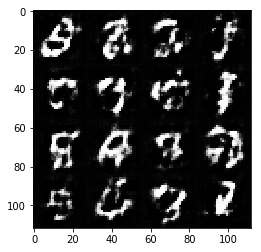

Epoch 1/2... Discriminator Loss: 0.6956 ... Generator Loss: 1.2331
Epoch 1/2... Discriminator Loss: 0.7895 ... Generator Loss: 0.9695
Epoch 1/2... Discriminator Loss: 0.9153 ... Generator Loss: 0.6377
Epoch 1/2... Discriminator Loss: 0.6746 ... Generator Loss: 1.0742
Epoch 1/2... Discriminator Loss: 0.7983 ... Generator Loss: 0.7784
Epoch 1/2... Discriminator Loss: 0.7757 ... Generator Loss: 0.8116
Epoch 1/2... Discriminator Loss: 0.5938 ... Generator Loss: 1.2256
Epoch 1/2... Discriminator Loss: 0.7263 ... Generator Loss: 1.6380
Epoch 1/2... Discriminator Loss: 0.6471 ... Generator Loss: 1.4458
Epoch 1/2... Discriminator Loss: 0.5865 ... Generator Loss: 1.5023


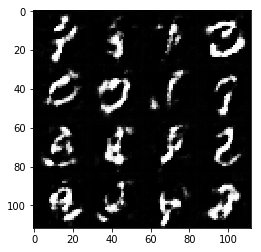

Epoch 1/2... Discriminator Loss: 0.7577 ... Generator Loss: 1.4282
Epoch 1/2... Discriminator Loss: 0.9322 ... Generator Loss: 0.6536
Epoch 1/2... Discriminator Loss: 1.3591 ... Generator Loss: 0.3606
Epoch 1/2... Discriminator Loss: 0.7272 ... Generator Loss: 1.3206
Epoch 1/2... Discriminator Loss: 1.5629 ... Generator Loss: 0.2717
Epoch 1/2... Discriminator Loss: 0.9824 ... Generator Loss: 0.5849
Epoch 1/2... Discriminator Loss: 0.9008 ... Generator Loss: 0.6867
Epoch 1/2... Discriminator Loss: 1.0107 ... Generator Loss: 0.5797
Epoch 1/2... Discriminator Loss: 1.0475 ... Generator Loss: 0.5690
Epoch 1/2... Discriminator Loss: 0.9789 ... Generator Loss: 0.6217


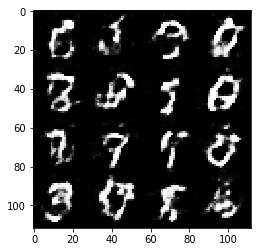

Epoch 1/2... Discriminator Loss: 1.0526 ... Generator Loss: 0.5310
Epoch 1/2... Discriminator Loss: 0.8005 ... Generator Loss: 0.9386
Epoch 1/2... Discriminator Loss: 0.8781 ... Generator Loss: 2.1068
Epoch 1/2... Discriminator Loss: 0.6719 ... Generator Loss: 1.6673
Epoch 1/2... Discriminator Loss: 1.0435 ... Generator Loss: 0.6068
Epoch 1/2... Discriminator Loss: 1.2240 ... Generator Loss: 0.4314
Epoch 1/2... Discriminator Loss: 0.7434 ... Generator Loss: 1.1505
Epoch 1/2... Discriminator Loss: 0.8637 ... Generator Loss: 1.8277
Epoch 1/2... Discriminator Loss: 0.7022 ... Generator Loss: 1.4323
Epoch 1/2... Discriminator Loss: 0.8758 ... Generator Loss: 0.7071


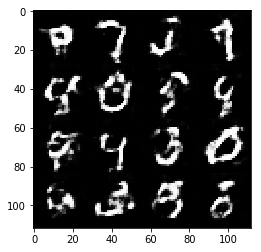

Epoch 1/2... Discriminator Loss: 0.8992 ... Generator Loss: 0.7301
Epoch 1/2... Discriminator Loss: 1.2258 ... Generator Loss: 0.4537
Epoch 1/2... Discriminator Loss: 0.9009 ... Generator Loss: 0.7348
Epoch 1/2... Discriminator Loss: 0.8912 ... Generator Loss: 1.0527
Epoch 1/2... Discriminator Loss: 0.8617 ... Generator Loss: 2.0052
Epoch 1/2... Discriminator Loss: 0.8404 ... Generator Loss: 1.3679
Epoch 1/2... Discriminator Loss: 0.7891 ... Generator Loss: 0.9847
Epoch 1/2... Discriminator Loss: 1.5927 ... Generator Loss: 0.2752
Epoch 1/2... Discriminator Loss: 1.0115 ... Generator Loss: 0.5953
Epoch 1/2... Discriminator Loss: 0.8748 ... Generator Loss: 0.7825


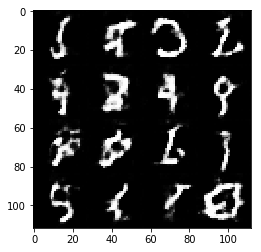

Epoch 1/2... Discriminator Loss: 0.7337 ... Generator Loss: 1.5333
Epoch 1/2... Discriminator Loss: 0.8056 ... Generator Loss: 0.9987
Epoch 1/2... Discriminator Loss: 0.9455 ... Generator Loss: 1.5336
Epoch 2/2... Discriminator Loss: 0.8531 ... Generator Loss: 0.8248
Epoch 2/2... Discriminator Loss: 0.9763 ... Generator Loss: 1.6326
Epoch 2/2... Discriminator Loss: 0.8659 ... Generator Loss: 1.4299
Epoch 2/2... Discriminator Loss: 0.8420 ... Generator Loss: 0.8962
Epoch 2/2... Discriminator Loss: 1.2440 ... Generator Loss: 0.4317
Epoch 2/2... Discriminator Loss: 1.1012 ... Generator Loss: 0.5512
Epoch 2/2... Discriminator Loss: 0.9848 ... Generator Loss: 1.5367


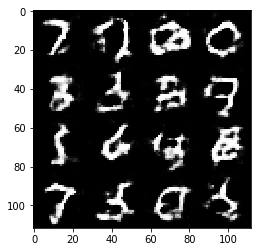

Epoch 2/2... Discriminator Loss: 0.8478 ... Generator Loss: 2.1077
Epoch 2/2... Discriminator Loss: 0.8140 ... Generator Loss: 0.9141
Epoch 2/2... Discriminator Loss: 0.7089 ... Generator Loss: 1.2553
Epoch 2/2... Discriminator Loss: 2.1383 ... Generator Loss: 0.1562
Epoch 2/2... Discriminator Loss: 0.9461 ... Generator Loss: 0.7139
Epoch 2/2... Discriminator Loss: 0.8726 ... Generator Loss: 0.7494
Epoch 2/2... Discriminator Loss: 0.8181 ... Generator Loss: 1.0408
Epoch 2/2... Discriminator Loss: 1.1380 ... Generator Loss: 0.4780
Epoch 2/2... Discriminator Loss: 0.9444 ... Generator Loss: 1.9437
Epoch 2/2... Discriminator Loss: 0.8362 ... Generator Loss: 0.8707


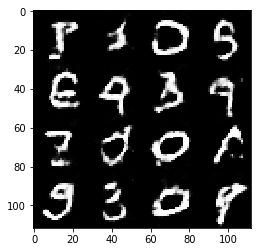

Epoch 2/2... Discriminator Loss: 0.9273 ... Generator Loss: 0.6733
Epoch 2/2... Discriminator Loss: 0.8324 ... Generator Loss: 0.7812
Epoch 2/2... Discriminator Loss: 1.1920 ... Generator Loss: 0.4622
Epoch 2/2... Discriminator Loss: 0.7419 ... Generator Loss: 1.1669
Epoch 2/2... Discriminator Loss: 1.1603 ... Generator Loss: 0.4687
Epoch 2/2... Discriminator Loss: 1.1122 ... Generator Loss: 0.4899
Epoch 2/2... Discriminator Loss: 0.9169 ... Generator Loss: 0.7011
Epoch 2/2... Discriminator Loss: 0.6540 ... Generator Loss: 1.3144
Epoch 2/2... Discriminator Loss: 1.0662 ... Generator Loss: 0.5322
Epoch 2/2... Discriminator Loss: 0.8326 ... Generator Loss: 0.7821


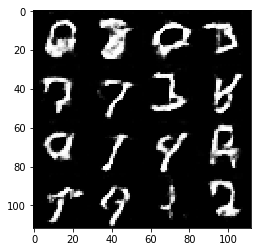

Epoch 2/2... Discriminator Loss: 0.8361 ... Generator Loss: 0.7586
Epoch 2/2... Discriminator Loss: 0.7680 ... Generator Loss: 1.8073
Epoch 2/2... Discriminator Loss: 1.3191 ... Generator Loss: 2.1127
Epoch 2/2... Discriminator Loss: 0.7810 ... Generator Loss: 0.8957
Epoch 2/2... Discriminator Loss: 0.7063 ... Generator Loss: 0.9759
Epoch 2/2... Discriminator Loss: 1.1314 ... Generator Loss: 0.4902
Epoch 2/2... Discriminator Loss: 0.7659 ... Generator Loss: 0.9162
Epoch 2/2... Discriminator Loss: 0.7059 ... Generator Loss: 1.1969
Epoch 2/2... Discriminator Loss: 0.8208 ... Generator Loss: 1.3030
Epoch 2/2... Discriminator Loss: 0.8341 ... Generator Loss: 0.8461


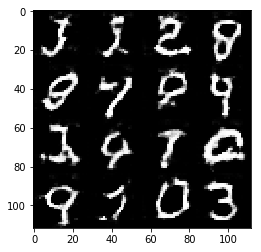

Epoch 2/2... Discriminator Loss: 1.0041 ... Generator Loss: 0.5936
Epoch 2/2... Discriminator Loss: 0.7148 ... Generator Loss: 0.9853
Epoch 2/2... Discriminator Loss: 0.7800 ... Generator Loss: 0.8491
Epoch 2/2... Discriminator Loss: 0.6849 ... Generator Loss: 1.7801
Epoch 2/2... Discriminator Loss: 0.7994 ... Generator Loss: 0.8258
Epoch 2/2... Discriminator Loss: 0.9082 ... Generator Loss: 0.6475
Epoch 2/2... Discriminator Loss: 1.0618 ... Generator Loss: 0.5276
Epoch 2/2... Discriminator Loss: 0.8299 ... Generator Loss: 0.7552
Epoch 2/2... Discriminator Loss: 0.5172 ... Generator Loss: 2.2304
Epoch 2/2... Discriminator Loss: 0.8261 ... Generator Loss: 1.4157


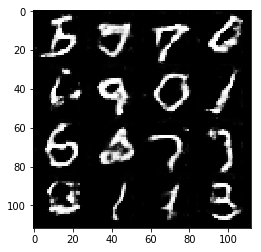

Epoch 2/2... Discriminator Loss: 0.6512 ... Generator Loss: 1.6402
Epoch 2/2... Discriminator Loss: 0.6211 ... Generator Loss: 1.1577
Epoch 2/2... Discriminator Loss: 0.5632 ... Generator Loss: 1.2025
Epoch 2/2... Discriminator Loss: 1.6046 ... Generator Loss: 0.2924
Epoch 2/2... Discriminator Loss: 0.7960 ... Generator Loss: 0.8416
Epoch 2/2... Discriminator Loss: 0.6406 ... Generator Loss: 1.4857
Epoch 2/2... Discriminator Loss: 0.6333 ... Generator Loss: 2.4664
Epoch 2/2... Discriminator Loss: 0.7221 ... Generator Loss: 0.9154
Epoch 2/2... Discriminator Loss: 0.9749 ... Generator Loss: 0.6064
Epoch 2/2... Discriminator Loss: 2.2207 ... Generator Loss: 0.1741


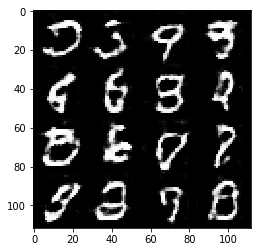

Epoch 2/2... Discriminator Loss: 0.7933 ... Generator Loss: 1.0386
Epoch 2/2... Discriminator Loss: 0.7655 ... Generator Loss: 1.0953
Epoch 2/2... Discriminator Loss: 0.9577 ... Generator Loss: 0.6251
Epoch 2/2... Discriminator Loss: 1.2588 ... Generator Loss: 0.4155
Epoch 2/2... Discriminator Loss: 0.6039 ... Generator Loss: 1.4407
Epoch 2/2... Discriminator Loss: 0.6948 ... Generator Loss: 1.2984
Epoch 2/2... Discriminator Loss: 0.8107 ... Generator Loss: 0.8384
Epoch 2/2... Discriminator Loss: 0.7574 ... Generator Loss: 0.9362
Epoch 2/2... Discriminator Loss: 1.1275 ... Generator Loss: 0.4810
Epoch 2/2... Discriminator Loss: 0.8553 ... Generator Loss: 0.7101


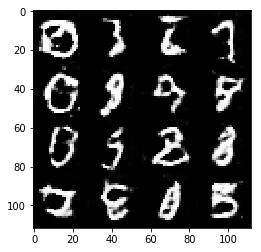

Epoch 2/2... Discriminator Loss: 0.9079 ... Generator Loss: 0.6322
Epoch 2/2... Discriminator Loss: 0.7674 ... Generator Loss: 0.9561
Epoch 2/2... Discriminator Loss: 0.5127 ... Generator Loss: 1.8056
Epoch 2/2... Discriminator Loss: 1.7786 ... Generator Loss: 3.1968
Epoch 2/2... Discriminator Loss: 0.6819 ... Generator Loss: 1.1849
Epoch 2/2... Discriminator Loss: 0.7840 ... Generator Loss: 0.8343
Epoch 2/2... Discriminator Loss: 0.7292 ... Generator Loss: 0.9339
Epoch 2/2... Discriminator Loss: 0.5833 ... Generator Loss: 1.6321
Epoch 2/2... Discriminator Loss: 0.9614 ... Generator Loss: 0.5734
Epoch 2/2... Discriminator Loss: 0.6255 ... Generator Loss: 1.1636


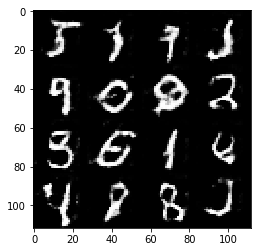

Epoch 2/2... Discriminator Loss: 1.1460 ... Generator Loss: 0.5012
Epoch 2/2... Discriminator Loss: 1.2374 ... Generator Loss: 0.4232
Epoch 2/2... Discriminator Loss: 0.5924 ... Generator Loss: 1.1903
Epoch 2/2... Discriminator Loss: 0.5169 ... Generator Loss: 1.5285
Epoch 2/2... Discriminator Loss: 0.5742 ... Generator Loss: 1.2510
Epoch 2/2... Discriminator Loss: 0.9352 ... Generator Loss: 0.6626
Epoch 2/2... Discriminator Loss: 0.6555 ... Generator Loss: 0.9948
Epoch 2/2... Discriminator Loss: 0.6762 ... Generator Loss: 0.9959
Epoch 2/2... Discriminator Loss: 0.5982 ... Generator Loss: 2.2609
Epoch 2/2... Discriminator Loss: 0.5615 ... Generator Loss: 1.3351


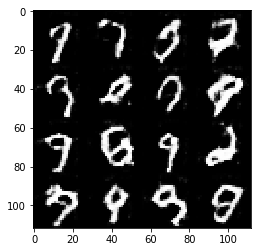

Epoch 2/2... Discriminator Loss: 0.7241 ... Generator Loss: 0.8594
Epoch 2/2... Discriminator Loss: 0.9779 ... Generator Loss: 3.4811
Epoch 2/2... Discriminator Loss: 0.5854 ... Generator Loss: 1.4670
Epoch 2/2... Discriminator Loss: 0.6630 ... Generator Loss: 1.0786
Epoch 2/2... Discriminator Loss: 0.6773 ... Generator Loss: 1.1291
Epoch 2/2... Discriminator Loss: 0.7736 ... Generator Loss: 0.8077
Epoch 2/2... Discriminator Loss: 0.6534 ... Generator Loss: 1.0731


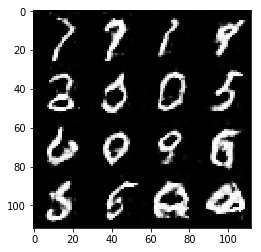

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2

epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### Try it on CelebA:

Epoch 1/1... Discriminator Loss: 2.3844 ... Generator Loss: 0.1669
Epoch 1/1... Discriminator Loss: 1.7493 ... Generator Loss: 0.4157
Epoch 1/1... Discriminator Loss: 1.1734 ... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.2129 ... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 0.8587 ... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 0.4036 ... Generator Loss: 1.5456
Epoch 1/1... Discriminator Loss: 0.4031 ... Generator Loss: 1.9982
Epoch 1/1... Discriminator Loss: 0.3790 ... Generator Loss: 2.0489
Epoch 1/1... Discriminator Loss: 0.4684 ... Generator Loss: 1.4106
Epoch 1/1... Discriminator Loss: 2.1476 ... Generator Loss: 0.1739


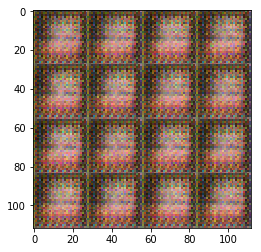

Epoch 1/1... Discriminator Loss: 0.5964 ... Generator Loss: 4.9512
Epoch 1/1... Discriminator Loss: 0.7909 ... Generator Loss: 0.9966
Epoch 1/1... Discriminator Loss: 0.6173 ... Generator Loss: 2.8526
Epoch 1/1... Discriminator Loss: 0.3283 ... Generator Loss: 2.2889
Epoch 1/1... Discriminator Loss: 0.4513 ... Generator Loss: 1.8003
Epoch 1/1... Discriminator Loss: 0.5028 ... Generator Loss: 1.3445
Epoch 1/1... Discriminator Loss: 0.3453 ... Generator Loss: 3.4249
Epoch 1/1... Discriminator Loss: 0.3331 ... Generator Loss: 2.1893
Epoch 1/1... Discriminator Loss: 0.2271 ... Generator Loss: 1.9599
Epoch 1/1... Discriminator Loss: 0.1604 ... Generator Loss: 2.3935


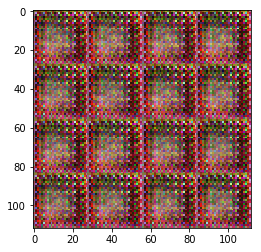

Epoch 1/1... Discriminator Loss: 0.2465 ... Generator Loss: 2.2356
Epoch 1/1... Discriminator Loss: 0.2477 ... Generator Loss: 2.1939
Epoch 1/1... Discriminator Loss: 0.2251 ... Generator Loss: 2.4942
Epoch 1/1... Discriminator Loss: 0.1420 ... Generator Loss: 2.4534
Epoch 1/1... Discriminator Loss: 0.1197 ... Generator Loss: 2.5392
Epoch 1/1... Discriminator Loss: 0.2087 ... Generator Loss: 2.2750
Epoch 1/1... Discriminator Loss: 0.1552 ... Generator Loss: 2.6176
Epoch 1/1... Discriminator Loss: 0.1363 ... Generator Loss: 2.9346
Epoch 1/1... Discriminator Loss: 0.3052 ... Generator Loss: 1.6887
Epoch 1/1... Discriminator Loss: 0.4944 ... Generator Loss: 1.1188


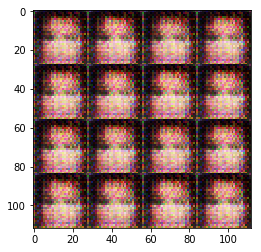

Epoch 1/1... Discriminator Loss: 0.8769 ... Generator Loss: 8.3999
Epoch 1/1... Discriminator Loss: 0.3538 ... Generator Loss: 1.9166
Epoch 1/1... Discriminator Loss: 0.2509 ... Generator Loss: 2.8251
Epoch 1/1... Discriminator Loss: 0.2261 ... Generator Loss: 3.3905
Epoch 1/1... Discriminator Loss: 0.3316 ... Generator Loss: 2.2582
Epoch 1/1... Discriminator Loss: 0.2922 ... Generator Loss: 1.9282
Epoch 1/1... Discriminator Loss: 0.2138 ... Generator Loss: 3.0283
Epoch 1/1... Discriminator Loss: 0.2116 ... Generator Loss: 2.2071
Epoch 1/1... Discriminator Loss: 0.3003 ... Generator Loss: 1.9007
Epoch 1/1... Discriminator Loss: 0.2365 ... Generator Loss: 2.0525


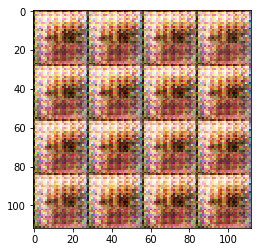

Epoch 1/1... Discriminator Loss: 0.2067 ... Generator Loss: 2.7578
Epoch 1/1... Discriminator Loss: 0.1648 ... Generator Loss: 2.5983
Epoch 1/1... Discriminator Loss: 0.1909 ... Generator Loss: 2.5433
Epoch 1/1... Discriminator Loss: 0.1577 ... Generator Loss: 2.6561
Epoch 1/1... Discriminator Loss: 0.1560 ... Generator Loss: 2.6747
Epoch 1/1... Discriminator Loss: 0.1108 ... Generator Loss: 3.0017
Epoch 1/1... Discriminator Loss: 0.1990 ... Generator Loss: 2.3643
Epoch 1/1... Discriminator Loss: 0.1315 ... Generator Loss: 2.8919
Epoch 1/1... Discriminator Loss: 0.1092 ... Generator Loss: 3.5062
Epoch 1/1... Discriminator Loss: 0.1914 ... Generator Loss: 5.0350


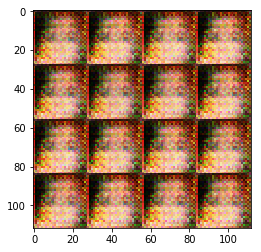

Epoch 1/1... Discriminator Loss: 0.1347 ... Generator Loss: 3.7893
Epoch 1/1... Discriminator Loss: 0.1053 ... Generator Loss: 3.0408
Epoch 1/1... Discriminator Loss: 0.1891 ... Generator Loss: 1.9919
Epoch 1/1... Discriminator Loss: 0.1425 ... Generator Loss: 2.7147
Epoch 1/1... Discriminator Loss: 0.1151 ... Generator Loss: 2.9269
Epoch 1/1... Discriminator Loss: 0.1529 ... Generator Loss: 4.2764
Epoch 1/1... Discriminator Loss: 0.1344 ... Generator Loss: 3.0439
Epoch 1/1... Discriminator Loss: 0.2028 ... Generator Loss: 2.4469
Epoch 1/1... Discriminator Loss: 0.1082 ... Generator Loss: 2.9588
Epoch 1/1... Discriminator Loss: 0.0804 ... Generator Loss: 3.1428


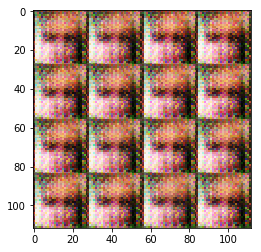

Epoch 1/1... Discriminator Loss: 0.1319 ... Generator Loss: 2.9278
Epoch 1/1... Discriminator Loss: 0.0995 ... Generator Loss: 3.0668
Epoch 1/1... Discriminator Loss: 0.0962 ... Generator Loss: 3.0736
Epoch 1/1... Discriminator Loss: 0.0767 ... Generator Loss: 3.3520
Epoch 1/1... Discriminator Loss: 0.1010 ... Generator Loss: 2.9457
Epoch 1/1... Discriminator Loss: 0.0609 ... Generator Loss: 3.0637
Epoch 1/1... Discriminator Loss: 0.0603 ... Generator Loss: 3.1385
Epoch 1/1... Discriminator Loss: 0.0596 ... Generator Loss: 3.2185
Epoch 1/1... Discriminator Loss: 0.0515 ... Generator Loss: 3.3702
Epoch 1/1... Discriminator Loss: 0.0597 ... Generator Loss: 3.3791


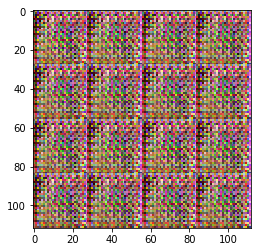

Epoch 1/1... Discriminator Loss: 0.0457 ... Generator Loss: 3.5866
Epoch 1/1... Discriminator Loss: 0.0392 ... Generator Loss: 3.6019
Epoch 1/1... Discriminator Loss: 0.0425 ... Generator Loss: 3.5470
Epoch 1/1... Discriminator Loss: 0.0356 ... Generator Loss: 3.5967
Epoch 1/1... Discriminator Loss: 0.0504 ... Generator Loss: 3.6044
Epoch 1/1... Discriminator Loss: 0.0483 ... Generator Loss: 3.4800
Epoch 1/1... Discriminator Loss: 0.0421 ... Generator Loss: 3.7818
Epoch 1/1... Discriminator Loss: 0.0461 ... Generator Loss: 3.8253
Epoch 1/1... Discriminator Loss: 0.1065 ... Generator Loss: 3.0426
Epoch 1/1... Discriminator Loss: 0.0666 ... Generator Loss: 3.5369


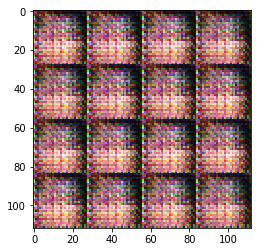

Epoch 1/1... Discriminator Loss: 0.0675 ... Generator Loss: 3.4334
Epoch 1/1... Discriminator Loss: 0.0695 ... Generator Loss: 4.6462
Epoch 1/1... Discriminator Loss: 0.0676 ... Generator Loss: 4.5305
Epoch 1/1... Discriminator Loss: 0.1588 ... Generator Loss: 2.3320
Epoch 1/1... Discriminator Loss: 0.0503 ... Generator Loss: 3.5986
Epoch 1/1... Discriminator Loss: 0.0686 ... Generator Loss: 3.6647
Epoch 1/1... Discriminator Loss: 0.3528 ... Generator Loss: 1.4189
Epoch 1/1... Discriminator Loss: 0.1121 ... Generator Loss: 2.6572
Epoch 1/1... Discriminator Loss: 0.1350 ... Generator Loss: 2.6028
Epoch 1/1... Discriminator Loss: 0.1467 ... Generator Loss: 2.4255


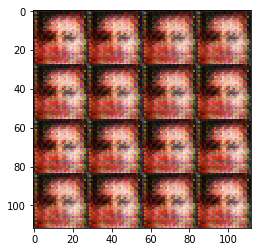

Epoch 1/1... Discriminator Loss: 0.1370 ... Generator Loss: 2.6024
Epoch 1/1... Discriminator Loss: 0.1004 ... Generator Loss: 2.9319
Epoch 1/1... Discriminator Loss: 0.0731 ... Generator Loss: 3.9033
Epoch 1/1... Discriminator Loss: 0.0832 ... Generator Loss: 3.2452
Epoch 1/1... Discriminator Loss: 0.0885 ... Generator Loss: 3.1820
Epoch 1/1... Discriminator Loss: 0.1229 ... Generator Loss: 2.4989
Epoch 1/1... Discriminator Loss: 0.0546 ... Generator Loss: 3.9625
Epoch 1/1... Discriminator Loss: 0.0790 ... Generator Loss: 3.2147
Epoch 1/1... Discriminator Loss: 1.9971 ... Generator Loss: 12.5516
Epoch 1/1... Discriminator Loss: 0.1934 ... Generator Loss: 2.2399


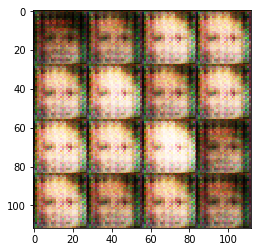

Epoch 1/1... Discriminator Loss: 0.1631 ... Generator Loss: 2.4519
Epoch 1/1... Discriminator Loss: 0.3723 ... Generator Loss: 1.6994
Epoch 1/1... Discriminator Loss: 0.4369 ... Generator Loss: 3.4013
Epoch 1/1... Discriminator Loss: 0.5760 ... Generator Loss: 1.2882
Epoch 1/1... Discriminator Loss: 0.8140 ... Generator Loss: 1.6352
Epoch 1/1... Discriminator Loss: 1.4499 ... Generator Loss: 6.4188
Epoch 1/1... Discriminator Loss: 0.4771 ... Generator Loss: 1.4944
Epoch 1/1... Discriminator Loss: 0.6048 ... Generator Loss: 0.9925
Epoch 1/1... Discriminator Loss: 0.5181 ... Generator Loss: 3.2513
Epoch 1/1... Discriminator Loss: 0.6614 ... Generator Loss: 1.3446


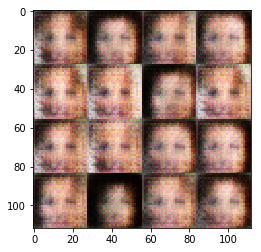

Epoch 1/1... Discriminator Loss: 0.9656 ... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.1392 ... Generator Loss: 0.5508
Epoch 1/1... Discriminator Loss: 0.7657 ... Generator Loss: 1.3411
Epoch 1/1... Discriminator Loss: 0.8885 ... Generator Loss: 2.4095
Epoch 1/1... Discriminator Loss: 1.5692 ... Generator Loss: 3.7474
Epoch 1/1... Discriminator Loss: 1.3373 ... Generator Loss: 0.4224
Epoch 1/1... Discriminator Loss: 0.8362 ... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 0.8446 ... Generator Loss: 3.2535
Epoch 1/1... Discriminator Loss: 0.7169 ... Generator Loss: 2.3528
Epoch 1/1... Discriminator Loss: 0.7562 ... Generator Loss: 2.5650


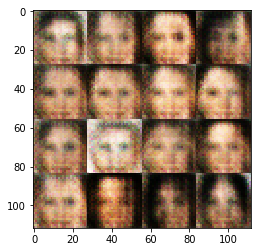

Epoch 1/1... Discriminator Loss: 1.1660 ... Generator Loss: 2.8932
Epoch 1/1... Discriminator Loss: 0.8590 ... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 0.8835 ... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.4932 ... Generator Loss: 0.3293
Epoch 1/1... Discriminator Loss: 1.1289 ... Generator Loss: 2.8449
Epoch 1/1... Discriminator Loss: 1.1567 ... Generator Loss: 3.0946
Epoch 1/1... Discriminator Loss: 0.7398 ... Generator Loss: 1.1442
Epoch 1/1... Discriminator Loss: 0.8075 ... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 1.3562 ... Generator Loss: 0.4171
Epoch 1/1... Discriminator Loss: 1.1614 ... Generator Loss: 0.5483


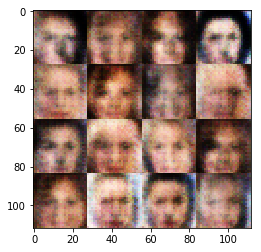

Epoch 1/1... Discriminator Loss: 1.0319 ... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 0.8056 ... Generator Loss: 1.0210
Epoch 1/1... Discriminator Loss: 0.9985 ... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 0.9745 ... Generator Loss: 1.8030
Epoch 1/1... Discriminator Loss: 0.8955 ... Generator Loss: 1.6113
Epoch 1/1... Discriminator Loss: 1.3195 ... Generator Loss: 2.0693
Epoch 1/1... Discriminator Loss: 0.9940 ... Generator Loss: 1.2683
Epoch 1/1... Discriminator Loss: 0.7924 ... Generator Loss: 1.2750
Epoch 1/1... Discriminator Loss: 0.8517 ... Generator Loss: 1.4307
Epoch 1/1... Discriminator Loss: 0.7511 ... Generator Loss: 1.2491


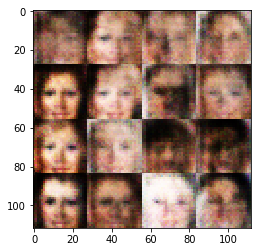

Epoch 1/1... Discriminator Loss: 0.8895 ... Generator Loss: 1.3958
Epoch 1/1... Discriminator Loss: 0.8312 ... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.3489 ... Generator Loss: 0.4110
Epoch 1/1... Discriminator Loss: 1.1455 ... Generator Loss: 0.5360
Epoch 1/1... Discriminator Loss: 1.0153 ... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.2547 ... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 1.0511 ... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.3336 ... Generator Loss: 0.4281
Epoch 1/1... Discriminator Loss: 1.3870 ... Generator Loss: 0.4108
Epoch 1/1... Discriminator Loss: 1.0317 ... Generator Loss: 0.6394


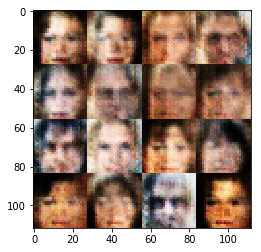

Epoch 1/1... Discriminator Loss: 1.0833 ... Generator Loss: 3.0515
Epoch 1/1... Discriminator Loss: 1.4071 ... Generator Loss: 0.4067
Epoch 1/1... Discriminator Loss: 0.9853 ... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.0000 ... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.0142 ... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.5739 ... Generator Loss: 0.3626
Epoch 1/1... Discriminator Loss: 0.7722 ... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 1.6865 ... Generator Loss: 0.2853
Epoch 1/1... Discriminator Loss: 0.7314 ... Generator Loss: 2.1871
Epoch 1/1... Discriminator Loss: 0.8885 ... Generator Loss: 0.9257


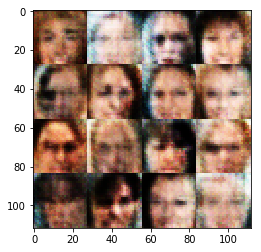

Epoch 1/1... Discriminator Loss: 1.4047 ... Generator Loss: 0.3854
Epoch 1/1... Discriminator Loss: 0.9350 ... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.3459 ... Generator Loss: 0.4271
Epoch 1/1... Discriminator Loss: 0.8599 ... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 0.9486 ... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 0.6154 ... Generator Loss: 2.9065
Epoch 1/1... Discriminator Loss: 0.7397 ... Generator Loss: 2.8689
Epoch 1/1... Discriminator Loss: 0.8558 ... Generator Loss: 2.9357
Epoch 1/1... Discriminator Loss: 0.6141 ... Generator Loss: 1.8637
Epoch 1/1... Discriminator Loss: 1.0932 ... Generator Loss: 2.1228


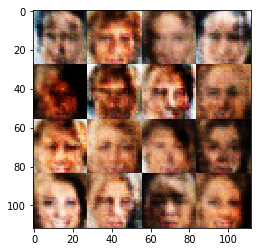

Epoch 1/1... Discriminator Loss: 0.7032 ... Generator Loss: 2.3705
Epoch 1/1... Discriminator Loss: 0.8809 ... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.5495 ... Generator Loss: 0.3254
Epoch 1/1... Discriminator Loss: 1.3654 ... Generator Loss: 0.4119
Epoch 1/1... Discriminator Loss: 0.8637 ... Generator Loss: 2.5238
Epoch 1/1... Discriminator Loss: 0.7995 ... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 0.5872 ... Generator Loss: 1.1430
Epoch 1/1... Discriminator Loss: 1.6825 ... Generator Loss: 0.2764
Epoch 1/1... Discriminator Loss: 0.8098 ... Generator Loss: 3.4127
Epoch 1/1... Discriminator Loss: 0.7481 ... Generator Loss: 2.4902


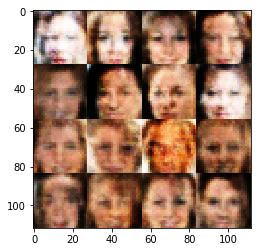

Epoch 1/1... Discriminator Loss: 1.5571 ... Generator Loss: 0.3183
Epoch 1/1... Discriminator Loss: 1.1743 ... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 0.7702 ... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 0.6641 ... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 0.7415 ... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.2611 ... Generator Loss: 0.4736
Epoch 1/1... Discriminator Loss: 0.7073 ... Generator Loss: 3.2292
Epoch 1/1... Discriminator Loss: 1.4544 ... Generator Loss: 0.3505
Epoch 1/1... Discriminator Loss: 1.0527 ... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 0.8600 ... Generator Loss: 0.7627


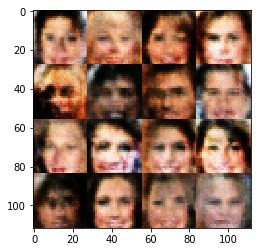

Epoch 1/1... Discriminator Loss: 1.4348 ... Generator Loss: 0.3563
Epoch 1/1... Discriminator Loss: 0.9391 ... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.2908 ... Generator Loss: 0.4173
Epoch 1/1... Discriminator Loss: 0.6376 ... Generator Loss: 3.8539
Epoch 1/1... Discriminator Loss: 0.6824 ... Generator Loss: 3.1479
Epoch 1/1... Discriminator Loss: 0.6064 ... Generator Loss: 1.4178
Epoch 1/1... Discriminator Loss: 0.4042 ... Generator Loss: 2.6353
Epoch 1/1... Discriminator Loss: 1.5709 ... Generator Loss: 0.2840
Epoch 1/1... Discriminator Loss: 1.4330 ... Generator Loss: 0.3767
Epoch 1/1... Discriminator Loss: 0.7215 ... Generator Loss: 0.9828


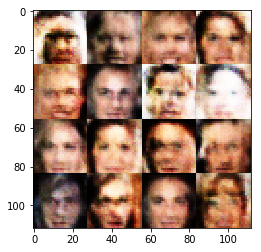

Epoch 1/1... Discriminator Loss: 0.4830 ... Generator Loss: 1.5048
Epoch 1/1... Discriminator Loss: 0.6918 ... Generator Loss: 1.1179
Epoch 1/1... Discriminator Loss: 1.8861 ... Generator Loss: 0.2463
Epoch 1/1... Discriminator Loss: 0.4778 ... Generator Loss: 1.5223
Epoch 1/1... Discriminator Loss: 0.7587 ... Generator Loss: 3.9243
Epoch 1/1... Discriminator Loss: 0.4942 ... Generator Loss: 1.5624
Epoch 1/1... Discriminator Loss: 0.8295 ... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3519 ... Generator Loss: 0.4260
Epoch 1/1... Discriminator Loss: 0.6690 ... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 0.6142 ... Generator Loss: 1.0806


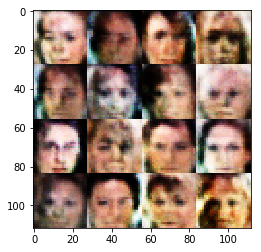

Epoch 1/1... Discriminator Loss: 0.5855 ... Generator Loss: 1.0829
Epoch 1/1... Discriminator Loss: 0.5756 ... Generator Loss: 3.0846
Epoch 1/1... Discriminator Loss: 0.7707 ... Generator Loss: 3.7078
Epoch 1/1... Discriminator Loss: 1.1519 ... Generator Loss: 2.5256
Epoch 1/1... Discriminator Loss: 1.2332 ... Generator Loss: 1.2310
Epoch 1/1... Discriminator Loss: 0.6415 ... Generator Loss: 2.7233
Epoch 1/1... Discriminator Loss: 0.7431 ... Generator Loss: 1.0372
Epoch 1/1... Discriminator Loss: 1.0729 ... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.1143 ... Generator Loss: 0.5976
Epoch 1/1... Discriminator Loss: 0.7739 ... Generator Loss: 1.0134


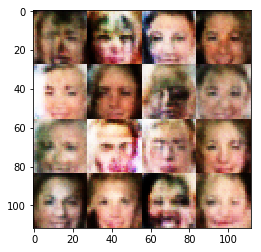

Epoch 1/1... Discriminator Loss: 0.9972 ... Generator Loss: 3.2445
Epoch 1/1... Discriminator Loss: 0.6802 ... Generator Loss: 2.4987
Epoch 1/1... Discriminator Loss: 1.1708 ... Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 1.2176 ... Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 0.8339 ... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 0.4303 ... Generator Loss: 1.8073
Epoch 1/1... Discriminator Loss: 0.8455 ... Generator Loss: 2.0440
Epoch 1/1... Discriminator Loss: 0.5729 ... Generator Loss: 2.9717
Epoch 1/1... Discriminator Loss: 1.3711 ... Generator Loss: 1.6257
Epoch 1/1... Discriminator Loss: 0.6471 ... Generator Loss: 2.3068


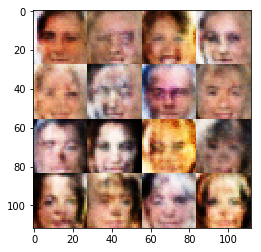

Epoch 1/1... Discriminator Loss: 0.4912 ... Generator Loss: 1.4289
Epoch 1/1... Discriminator Loss: 0.6472 ... Generator Loss: 1.5301
Epoch 1/1... Discriminator Loss: 0.5907 ... Generator Loss: 3.2379
Epoch 1/1... Discriminator Loss: 2.2802 ... Generator Loss: 1.8039
Epoch 1/1... Discriminator Loss: 0.9906 ... Generator Loss: 1.6023
Epoch 1/1... Discriminator Loss: 0.6408 ... Generator Loss: 1.8130
Epoch 1/1... Discriminator Loss: 0.7848 ... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 0.4488 ... Generator Loss: 1.9067
Epoch 1/1... Discriminator Loss: 0.5023 ... Generator Loss: 1.6527
Epoch 1/1... Discriminator Loss: 1.2266 ... Generator Loss: 2.9454


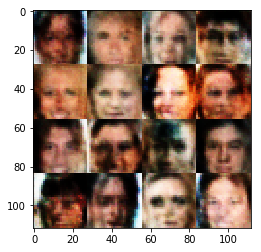

Epoch 1/1... Discriminator Loss: 0.7023 ... Generator Loss: 1.6919
Epoch 1/1... Discriminator Loss: 1.1403 ... Generator Loss: 2.4463
Epoch 1/1... Discriminator Loss: 1.2313 ... Generator Loss: 1.3254
Epoch 1/1... Discriminator Loss: 0.9663 ... Generator Loss: 1.1498
Epoch 1/1... Discriminator Loss: 0.9595 ... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 0.9530 ... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 0.8061 ... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 0.5506 ... Generator Loss: 1.6716
Epoch 1/1... Discriminator Loss: 0.6609 ... Generator Loss: 1.0357
Epoch 1/1... Discriminator Loss: 0.7372 ... Generator Loss: 0.9113


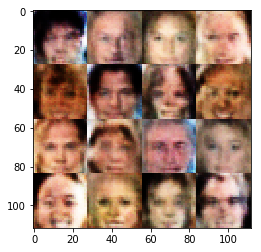

Epoch 1/1... Discriminator Loss: 0.6931 ... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 0.6278 ... Generator Loss: 1.1991
Epoch 1/1... Discriminator Loss: 0.8288 ... Generator Loss: 2.9797
Epoch 1/1... Discriminator Loss: 1.3743 ... Generator Loss: 1.7993
Epoch 1/1... Discriminator Loss: 0.6657 ... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 0.7432 ... Generator Loss: 1.2938
Epoch 1/1... Discriminator Loss: 0.6618 ... Generator Loss: 2.1138
Epoch 1/1... Discriminator Loss: 1.2257 ... Generator Loss: 0.4667
Epoch 1/1... Discriminator Loss: 1.3009 ... Generator Loss: 0.4416
Epoch 1/1... Discriminator Loss: 0.6155 ... Generator Loss: 1.2174


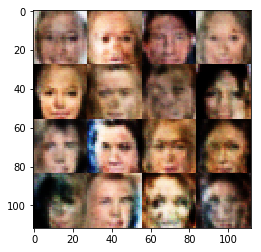

Epoch 1/1... Discriminator Loss: 0.4647 ... Generator Loss: 2.1471
Epoch 1/1... Discriminator Loss: 0.6045 ... Generator Loss: 1.6180
Epoch 1/1... Discriminator Loss: 0.4417 ... Generator Loss: 1.9910
Epoch 1/1... Discriminator Loss: 1.8933 ... Generator Loss: 2.5379
Epoch 1/1... Discriminator Loss: 1.0031 ... Generator Loss: 1.4012
Epoch 1/1... Discriminator Loss: 1.1481 ... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 0.8012 ... Generator Loss: 1.3091
Epoch 1/1... Discriminator Loss: 0.8702 ... Generator Loss: 2.9362
Epoch 1/1... Discriminator Loss: 0.7308 ... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.1524 ... Generator Loss: 0.5056


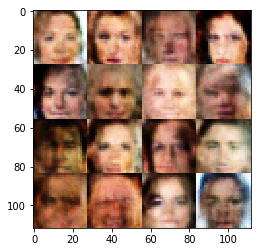

Epoch 1/1... Discriminator Loss: 1.1441 ... Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 0.7176 ... Generator Loss: 1.0046
Epoch 1/1... Discriminator Loss: 0.7104 ... Generator Loss: 1.1191
Epoch 1/1... Discriminator Loss: 0.7863 ... Generator Loss: 3.1565
Epoch 1/1... Discriminator Loss: 0.6478 ... Generator Loss: 1.7381
Epoch 1/1... Discriminator Loss: 0.9397 ... Generator Loss: 3.3679
Epoch 1/1... Discriminator Loss: 1.3113 ... Generator Loss: 1.9276
Epoch 1/1... Discriminator Loss: 0.8261 ... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 0.7741 ... Generator Loss: 1.1145
Epoch 1/1... Discriminator Loss: 0.6097 ... Generator Loss: 1.7873


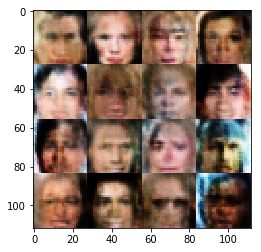

Epoch 1/1... Discriminator Loss: 0.6894 ... Generator Loss: 1.4751
Epoch 1/1... Discriminator Loss: 0.4837 ... Generator Loss: 2.3287
Epoch 1/1... Discriminator Loss: 0.4469 ... Generator Loss: 2.6861
Epoch 1/1... Discriminator Loss: 0.6730 ... Generator Loss: 2.6959
Epoch 1/1... Discriminator Loss: 0.8202 ... Generator Loss: 2.3168
Epoch 1/1... Discriminator Loss: 0.8540 ... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 0.6012 ... Generator Loss: 2.3216
Epoch 1/1... Discriminator Loss: 0.9891 ... Generator Loss: 1.9990
Epoch 1/1... Discriminator Loss: 0.6263 ... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 0.7714 ... Generator Loss: 0.9395


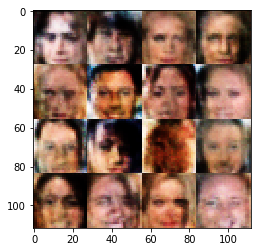

Epoch 1/1... Discriminator Loss: 0.5659 ... Generator Loss: 1.1924
Epoch 1/1... Discriminator Loss: 0.6497 ... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 0.4155 ... Generator Loss: 2.4712
Epoch 1/1... Discriminator Loss: 0.6958 ... Generator Loss: 2.4968
Epoch 1/1... Discriminator Loss: 1.6028 ... Generator Loss: 1.5601
Epoch 1/1... Discriminator Loss: 0.8578 ... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 0.7751 ... Generator Loss: 1.7729
Epoch 1/1... Discriminator Loss: 0.5773 ... Generator Loss: 1.7312
Epoch 1/1... Discriminator Loss: 0.5285 ... Generator Loss: 1.9847
Epoch 1/1... Discriminator Loss: 0.4879 ... Generator Loss: 1.9589


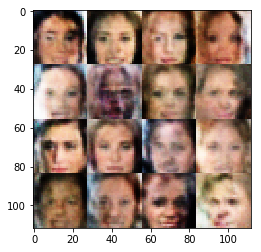

Epoch 1/1... Discriminator Loss: 1.4366 ... Generator Loss: 2.5396
Epoch 1/1... Discriminator Loss: 0.5746 ... Generator Loss: 1.2351
Epoch 1/1... Discriminator Loss: 0.6146 ... Generator Loss: 1.2804
Epoch 1/1... Discriminator Loss: 0.5697 ... Generator Loss: 1.2918
Epoch 1/1... Discriminator Loss: 0.3410 ... Generator Loss: 1.9490
Epoch 1/1... Discriminator Loss: 0.9632 ... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 0.8107 ... Generator Loss: 3.4621
Epoch 1/1... Discriminator Loss: 1.6193 ... Generator Loss: 1.3874
Epoch 1/1... Discriminator Loss: 0.6724 ... Generator Loss: 2.2283
Epoch 1/1... Discriminator Loss: 1.1270 ... Generator Loss: 0.4918


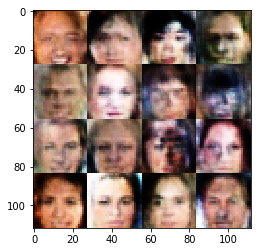

Epoch 1/1... Discriminator Loss: 0.6788 ... Generator Loss: 1.0227
Epoch 1/1... Discriminator Loss: 0.5199 ... Generator Loss: 1.3552
Epoch 1/1... Discriminator Loss: 0.5808 ... Generator Loss: 1.7816
Epoch 1/1... Discriminator Loss: 0.3813 ... Generator Loss: 2.4833
Epoch 1/1... Discriminator Loss: 0.9090 ... Generator Loss: 1.5867
Epoch 1/1... Discriminator Loss: 1.2978 ... Generator Loss: 0.4312


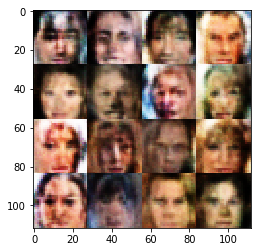

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

It looks like my model works :) 